## Alpha Wave Analysis Tutorial: The "Hello World" of EEG
Welcome to our BCI-within-Reach tutorial series! 
We're starting with the alpha wave: the strongest brainsigal we can observe in a healthy brain. It occurs when parts of you are in a state of idle, or relaxation.

EEG signals come from clusters of brain cells (neurons) acting synchronously. Think about a football stadium: A stadium full of unique conversations, to a far away observer, sounds like incomprehensible static. But when the crowd synchronizes and chants together- then we can understand what they are saying, even from far away. 

The alpha wave is one of these synchronized neural "chants": it's an inhibitory signal intended to keep inactive parts of your brain in standby. You can put a big part of your brain- your visual center- in standby mode when you close your eyes. 
* Eyes open: quiet alpha signals. 
* Eyes closed: strong ones!

It cycles pretty slow- about 8-12 times a second, and is very strong compared to most brain signals.

Let's jump in!
We'll use standard open-source packages to explore three key attributes of this neural signal:
- Amplitude: The signal's "loudness" or strength.
- Frequency (Hz): Its cycles per second.
- Location: different parts of our brains do different things- here we'll get to see the part that processes vision!

We'll: 
1) load data from the MOABB project 
2) prep it (sensor location, denoise)
3) visualize the alpha signal. Let's get started!

This tutorial is more about getting started and introducing concepts and BCI-lingo!

In [2]:
# python imports 

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import mne
from moabb.datasets import Rodrigues2017
import pprint


# Loading Data and Initial Setup

We are using the `Rodrigues2017` dataset from MOABB. This dataset contains Eyes Open (EO) and Eyes Closed (EC) epochs, which is exactly what we need for the **Alpha Wave 'Hello World'** exercise described in the tutorial.

This initial block downloads the data (if necessary) and creates the nested dictionary structure containing the MNE `Raw` objects.

In [3]:
# 1. Initialize the Dataset
dataset = Rodrigues2017()
subject_id = dataset.subject_list[1]
subj_list = [subject_id]

# 2. Load the Raw Data Structure
raw_data_dict = dataset.get_data(subjects=subj_list)
pprint.pprint(f'Subject Id loaded:{subj_list}')

raw = raw_data_dict[subject_id]['0']['0'] # some moabb specific parsing gets the MNE raw object

# 3) convert to microvolts instead of volts
raw._data *= 10**6

print("\n--- First MNE Raw Object Details (Subject {}) ---".format(subject_id))
print(f"Data Type: {type(raw)}")
print(f"Sampling Rate: {raw.info['sfreq']} Hz")
print(f"Number of Channels: {len(raw.info['ch_names'])}")
print(f"Total Duration: {raw.times[-1]:.2f} seconds")


'Subject Id loaded:[2]'

--- First MNE Raw Object Details (Subject 2) ---
Data Type: <class 'mne.io.array._array.RawArray'>
Sampling Rate: 512.0 Hz
Number of Channels: 17
Total Duration: 358.69 seconds


## EEG Metadata in Time: "Events"
In brain recordings, an "event" is a time stamp that marks the exact moment we *expect* a signal to occur.

An event can be the time a stimulus was presented (like a sound or image) or a time a person performed an action (like a button press). It can also mark the duration a person is doing a certain mental task.

Many of us have heard how important labels are for AI/ML algorithms. For neural data, events are some of the most imporant labels. They allow us to pinpoint the brain's activity "time locked" to that specific occurrence.

The events here indicate when a person is told to close their eyes, and then open their eyes. As you can see, there are repeats of this throughout the recording. These repeats of the same events that mark a "condition" are called often called trials or blocks. Repeated trials are very important for resolving the signal with standard analyses- averaging across these trials improves noise. 

We'll cover signal averaging in greater detail in future tutorials, but in short, the concept is similar to taking a long exposure shot in low light settings.


Stim Channel Events:
Used Annotations descriptions: ['closed', 'open']


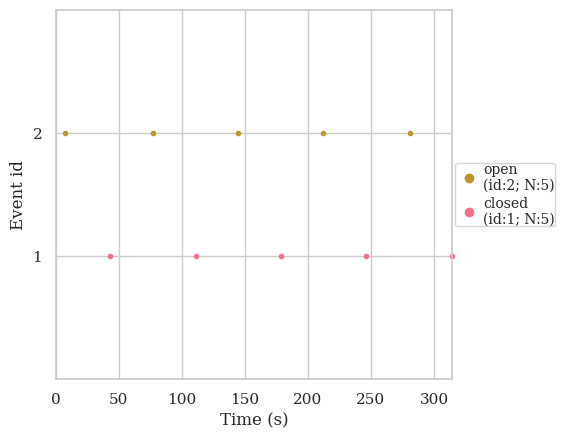

In [4]:

# Check the event channels to verify the task data
print("\nStim Channel Events:")
events, event_id = mne.events_from_annotations(raw)

mne.viz.plot_events(events, event_id = event_id, sfreq=raw.info['sfreq']);

## EEG metadata in Space: the sensor layout (montage)
1) EEG sensors are placed on spots on the head. 
- to capture these locations, each sensor has coordinates and usually a standardized name. 
- The most common standard for EEG sensor locations is called the 10-20 montage.
2) we need to rename some sensors here- not standardized part of the flow, but not uncommon to have to do some manual data standardization.
3) Simple pre-processing- we'll dig into different filters and why later, but for now, we just do a standard "common average reference (CAR) to the EEG channels"
We load a standard montage (electrode positions) and apply it to the `raw` data. This is essential for plotting topographic maps later (Cells 7 & 8) to show *where* the Alpha wave is strongest, as described in the tutorial's **'Where is this signal coming from?'** section (the visual cortex/occipital lobe).



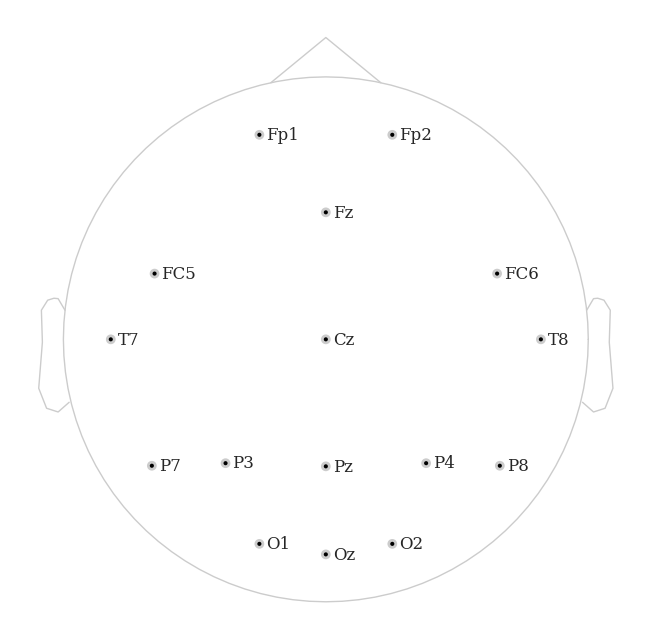

EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.


In [5]:
# 1) load in montage. Biosemi is an EEG manufacturer. 64 means it has 64 sensors.
montage = mne.channels.make_standard_montage('biosemi64')


# 2) rename the sensors - not always required, but usually some weird discrepancy exists to manage. 
rename_targets = ['Fc5', 'Fc6'] # 'Fc5'-> 'FC5', 'Fc6'-> 'FC6'
name_map = {name: name.upper() for name in raw.info['ch_names'] if name in rename_targets}
raw.rename_channels(name_map)

# Set the montage and see where your sensors are! We only have a subset of the full coverage cap here, but enough to see the alpha wave.
raw.set_montage(montage, on_missing='ignore'); 
raw.plot_sensors(kind="topomap",show_names = True);

# setting the reference is a preproccessing step- sort of like a simple version of the noise cancelling on noise cancelling headphones. 
# Basic idea is, in an ideal situation you have a sensor that records noise, and sensor that records noise+sigal.
# (signal+noise) - noise = signal!
# This is an easy dataset: good data collection, and alpha is a strong signal- we don't have to do anything fancy here to see signal
raw.set_eeg_reference('average');

# The 'Hello World' Plot (PSD Comparison)

This block is the core validation of the Alpha Wave 'Hello World' phenomenon. We perform the following steps:
1. Using the "event" timestmps we looked at earlier, we are going to clip the data into snippets of the segments where the eyes are closed (EC), and segments where the eyes are open (EO). 
    * Jargon Alert: These segments are often called "Epochs" in neural data analysis. This step is called "Epoching"
2. Compute the Power Spectral Density (PSD) for each condition 
    * Essentially the strength of each frequency 
    * tech details: using Welch's method (spectral analysis).
3. Plot the average PSD for EO and EC across all channels. 

We expect to see a clear peak in the 7–13 Hz (Alpha) band in the **Eyes Closed** condition that is significantly **higher** than the Eyes Open condition, proving the wave is 'loud' when eyes are closed.

512.0
Not setting metadata
10 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 10 events and 5121 original time points ...
0 bad epochs dropped
Effective window size : 3.000 (s)
Effective window size : 3.000 (s)


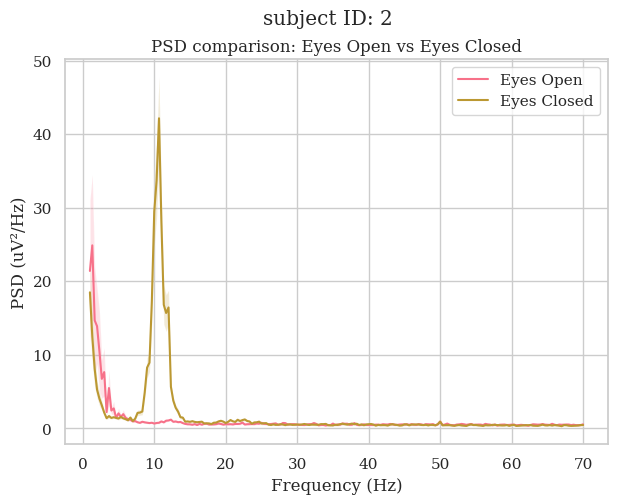

In [6]:
fs = raw.info["sfreq"] 
print(fs)

# Step 1: epoch by condition
epochs = mne.Epochs(raw, events, event_id=event_id, tmin=0, tmax=10,baseline=None, detrend=1, preload=True,event_repeated="drop" )

# Split by condition
epochs_eo = epochs["open"]
epochs_ec = epochs["closed"]

win = 3
# Step 2: compute PSDs
psd_eo = epochs_eo.compute_psd(method="welch", fmin=1, fmax=70, n_fft=int(fs*win))
psd_ec = epochs_ec.compute_psd(method="welch", fmin=1, fmax=70, n_fft=int(fs*win))

freqs = psd_eo.freqs
pow_eo = np.median(psd_eo.get_data(),axis=0) # median across epochs → shape n_channels x n_freqs
pow_ec = np.median(psd_ec.get_data(),axis=0)

# Step 3: average over channels
mean_eo, sem_eo = pow_eo.mean(0), pow_eo.std(0, ddof=1)/np.sqrt(pow_eo.shape[0])
mean_ec, sem_ec = pow_ec.mean(0), pow_ec.std(0, ddof=1)/np.sqrt(pow_ec.shape[0])

# Step 4: plot
plt.figure(figsize=(7,5))
plt.plot(freqs, mean_eo, label="Eyes Open")
plt.fill_between(freqs, mean_eo-sem_eo, mean_eo+sem_eo, alpha=0.2)
plt.plot(freqs, mean_ec, label="Eyes Closed")
plt.fill_between(freqs, mean_ec-sem_ec, mean_ec+sem_ec, alpha=0.2)
plt.xlabel("Frequency (Hz)")
plt.ylabel("PSD (uV²/Hz)")
plt.title("PSD comparison: Eyes Open vs Eyes Closed")
plt.legend()
plt.suptitle(f'subject ID: {subject_id}')
plt.show()




### Localizing the Alpha Wave

Kind of like how we all have faces, but they look different, everyone's brains are a bit different too (within a generally shared structure). 

* For alpha waves, they can vary in strength, location (to a degree) and also frequency.
* Think of it like some people's alpha waves a slightly different pitch than others.

This block identifies the **Individual Alpha Peak Frequency (IAF)** by finding where the difference between Eyes Closed (EC) and Eyes Open (EO) power is greatest. 

We then plot the topographic map (topomap) of the difference in power (EC minus EO) for that specific Alpha band.

* We expect the topomap to show a high concentration of power increase over the back of the head, confirming the Alpha wave's origin in the **visual cortex of the occipital lobe**, as discussed in the tutorial.
* If we "tune in" to someones individual frequency, we get a better signal compared to using the general range!

For reference, we'll see this visual alpha signal in the "O" sensors in the 10-20 layout. This "O" stands for occipital lobe which is in the back of your head. This brain area is related to visual processing.

The diagram below shows where the Occipital sensors are, as well as what brain areas are generally below them (the visual areas- we don't need to get more specific than that for now!).

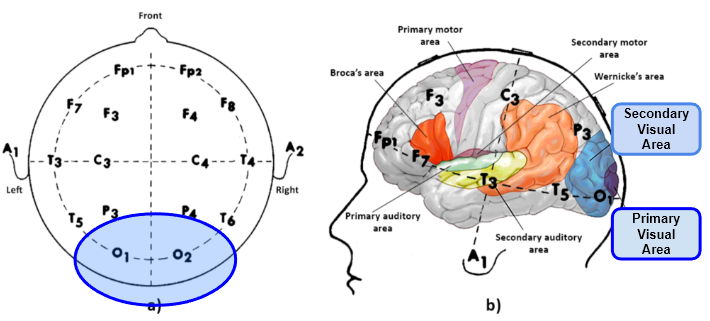

image adapted from https://www.mdpi.com/2076-3417/11/2/674

Text(0.5, 1.1, 'Subject 2')

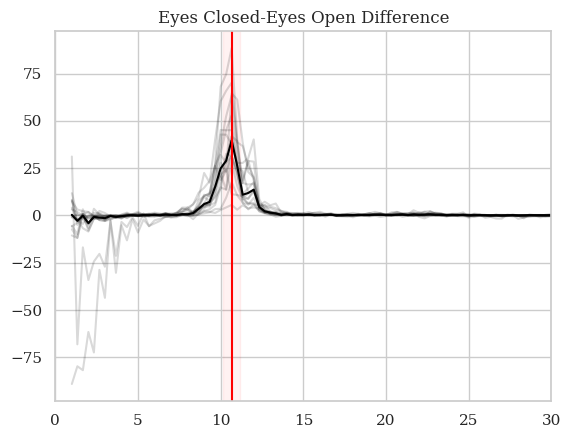

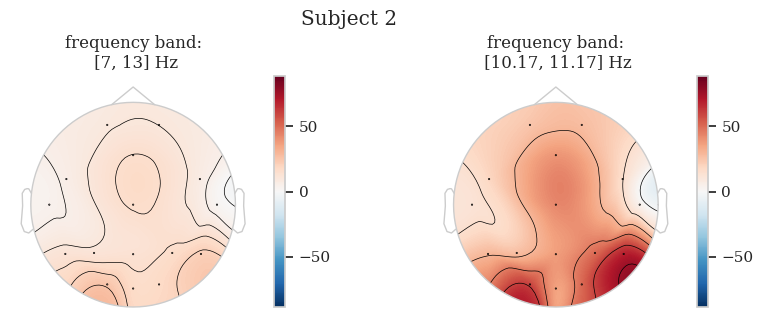

In [7]:

# TODO: Must be cleaned up - turn this into a SHORT function within this cell
p_diff = pow_ec.T-pow_eo.T

# Define the Alpha band search range (8 Hz to 13 Hz)
alpha_min, alpha_max = 8.0, 13.0

# 1. Create a boolean mask to select indices within the Alpha range
alpha_mask = (freqs >= alpha_min) & (freqs <= alpha_max)

# 2. Slice both the PSD and Freqs arrays using the mask
alpha_psd = p_diff[alpha_mask,]
alpha_freqs = freqs[alpha_mask]

# 3. Find the index of the maximum power in the Alpha-specific PSD
peak_alpha_index = np.argmax(np.median(alpha_psd,axis = 1))

# 4. Use that index to look up the corresponding peak frequency
peak_alpha_frequency = np.round(alpha_freqs[peak_alpha_index],2)

individual_alpha = [peak_alpha_frequency-.5,peak_alpha_frequency+.5]


plt.plot(freqs,p_diff,'k',alpha = 0.15)
plt.plot(freqs,np.median(p_diff,axis = 1),'k')
plt.axvline(peak_alpha_frequency,color ='red')
plt.axvspan(individual_alpha[0],individual_alpha[1],color ='red',alpha =.05)
plt.xlim([0,30])
plt.title('Eyes Closed-Eyes Open Difference')


# Plot "topomaps" of the differences in power, for "general" alpha band, and subject-specific alpha band
fig, ax = plt.subplots(1,2,figsize = (10,3))
picks = mne.pick_types(epochs.info, eeg=True, meg=False,exclude='bads')
pos = mne.channels.layout._find_topomap_coords(epochs.info, picks)


f_ind_alpha = np.logical_and(freqs > individual_alpha[0], freqs <= individual_alpha[1])
mx = np.max(p_diff[f_ind_alpha,])
for i,f_lims in enumerate([[7,13],individual_alpha]):
    f_id = np.logical_and(freqs > f_lims[0], freqs <= f_lims[1])
    vals_to_plot  = p_diff[f_id,].mean(axis =0)
    # mx = np.max(p_diff[:,])#np.max(np.abs(vals_to_plot))
    im, _ = mne.viz.plot_topomap(vals_to_plot, pos , axes=ax[i], show=False,vlim = (-mx, mx),cmap = 'RdBu_r')
    ax[i].set_title(f'frequency band:\n {f_lims} Hz')
    plt.colorbar(im)

fig.suptitle(f'Subject {subject_id}',y=1.1)

### How the strength of the alpha signal changes when visual system goes on standby
### The Time-Domain Alpha "Envelope"

To see how the strength (or amplitude) Alpha wave changes when the visual system goes on standby, we calculate the envelope of the Alpha band (7-13 Hz) on the occipital channels (O1, O2, Oz). 

We use the robust MNE method `raw.apply_hilbert(envelope=True)` after band-pass filtering, and then apply a final low-pass filter to smooth the envelope for a clean line plot. The resulting line plot should show high amplitude during the EC periods and low amplitude during the EO periods.

NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).


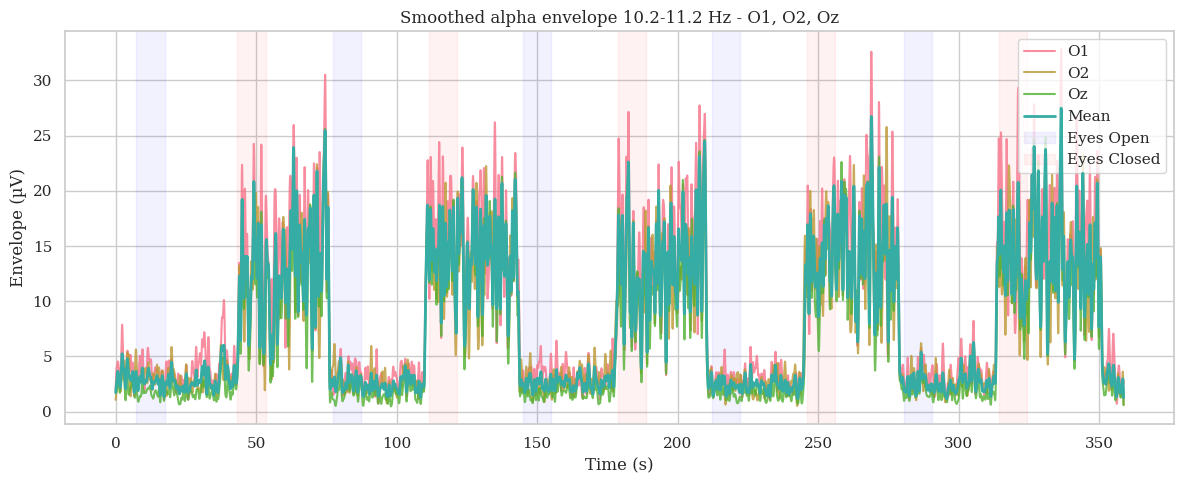

In [8]:


# Params from IAF calculation
fmin_alpha = individual_alpha[0]
fmax_alpha = individual_alpha[1]
channel_names = ["O1", "O2", "Oz"]
smooth_lp_hz =.1 # low-pass cutoff for smoothing the envelope

# 1) Band-pass selected channels
raw_alpha = raw.copy().pick_channels(channel_names)
raw_alpha.filter(l_freq=fmin_alpha, h_freq=fmax_alpha, fir_design="firwin", verbose=False)

# 2) Hilbert envelope (using the robust MNE method for Raw objects)
raw_alpha.apply_hilbert(envelope=True, n_fft="auto", verbose=False)

# 3) Extract (n_channels, n_times) and timebase
env = raw_alpha.get_data() # V
times = raw_alpha.times
sfreq = float(raw.info["sfreq"])

# 4) Smooth each channel's envelope (vectorized over channels)
env_smooth = mne.filter.filter_data(
env, sfreq=sfreq, l_freq=None, h_freq=smooth_lp_hz,
fir_design="firwin", verbose=False
)

# 5) Plot per channel, plus mean
fig, ax = plt.subplots(figsize=(12, 5))
for i, ch in enumerate(raw_alpha.info.ch_names):
    ax.plot(times, env_smooth[i] , label=ch, alpha=0.8)

mean_env = env_smooth.mean(axis=0)
ax.plot(times, mean_env , linewidth=2.0, label="Mean", zorder=10)

ax.set_title(f"Smoothed alpha envelope {fmin_alpha:.1f}-{fmax_alpha:.1f} Hz - {', '.join(channel_names)}")
ax.set_xlabel("Time (s)")
ax.set_ylabel("Envelope (µV)")
ax.grid(True)
ax.legend()
plt.tight_layout()


annotations = raw.annotations
has_eo, has_ec = False, False
for ann in annotations:
    if ann["description"] == "open":
        ax.axvspan(
            ann["onset"],
            ann["onset"] + ann["duration"],
            color="blue",
            alpha=0.05,
            label="Eyes Open" if not has_eo else "",
        )
        has_eo = True
    elif ann["description"] == "closed":
        ax.axvspan(
            ann["onset"],
            ann["onset"] + ann["duration"],
            color="red",
            alpha=0.05,
            label="Eyes Closed" if not has_ec else "",
        )
        has_ec = True

ax.legend(loc="upper right")

plt.show()

Next, go to the top and run through other subjects in the list by changing:
subject_id = dataset.subject_list[idx]
where idx is just some integer, however many elements are in the subject list. 

You'll see something important and interesting

everyone's brain, when doing the same thing (opening and closing their eyes) looks different!! 

in general, you should see some changes in this alpha frequency in the back of the head. these are two different people


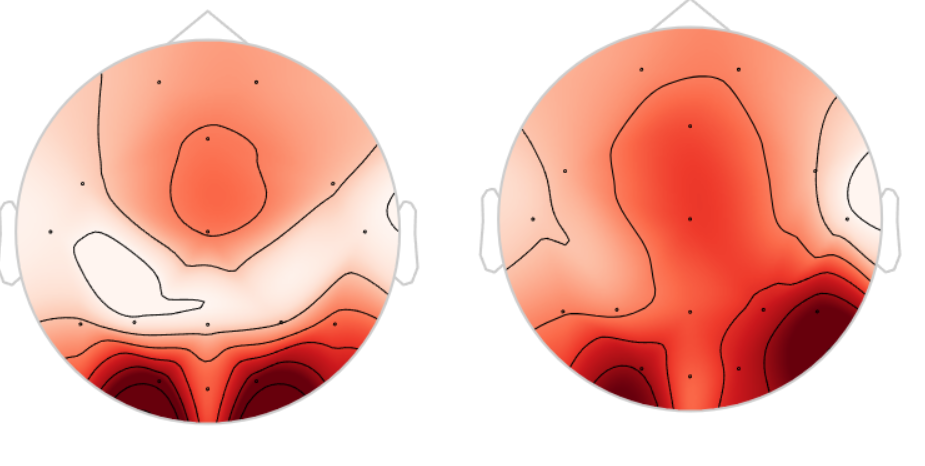

But you'll also notice, that with the exact same processing, some people just don't show strong signals.

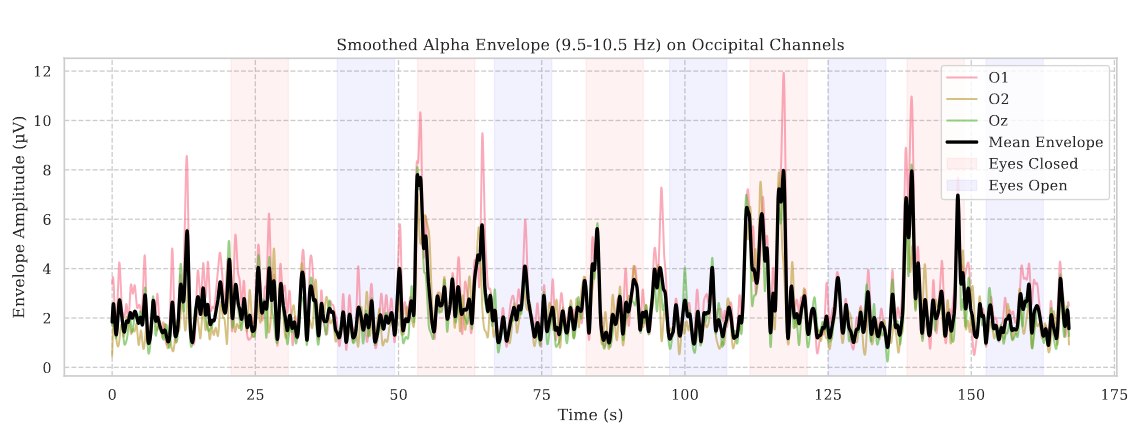


### Consider this just a preview of something interesting about humans! 

We share similar characteristics, but are all different. 

Kind of like we all generally have the same facial features, but at the end of the day look unique.

This is an important thing to consideer when dealing with biological signals!! 

We don't get into it now, but thought it could be a fun point of exploration for anyone looking at this to just 'see' the differences in people. 


Thanks so much for reading! And feel free to reach out with any questions.

- AJ @syncrograph